### point-to-point ICP (Iterative Closest Point) registration

In [ ]:
import numpy as np
import pandas as pd
import open3d as o3d
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.mplot3d import Axes3D


def load_point_clouds(*files, voxel_size=0.01):
    point_clouds = []

    for file in files:
        pcd = o3d.io.read_point_cloud(file)
        pcd = pcd.voxel_down_sample(voxel_size=voxel_size)  # Downsampling for faster processing
        point_clouds.append(pcd)

    return point_clouds

def get_random_transformation():
    Transformation = np.eye(4) # Initialize a 4x4 identity matrix (Homogeneous)
    Transformation[:3, :3] = special_ortho_group.rvs(3) # Random rotation matrix
    Transformation[:3, 3] = np.random.rand(3) # Random translation vector
    return Transformation

def ICP(pcd1, pcd2, T_init, threshold=0.2):
    icp_result = o3d.pipelines.registration.registration_icp(
        pcd1, pcd2, threshold, T_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint() # Point to Point Alignment
    )
    return icp_result

file1 = "selected_pcds/pointcloud_0000.pcd"
file2 = "selected_pcds/pointcloud_0004.pcd"

pcd1, pcd2 = load_point_clouds(file1, file2)
Init_Transformation = get_random_transformation()
icp_result = ICP(pcd1, pcd2, Init_Transformation)

print("Initial Transformation Matrix:")
print(Init_Transformation)
print("ICP Learned Transformation Matrix:")
print(icp_result.transformation)
print(f"Initial Fitness: {icp_result.fitness}")
print(f"Inlier RMSE: {icp_result.inlier_rmse}")

# Visualize result
pcd2.transform(icp_result.transformation) # Apply the transformation to pcd2
o3d.visualization.draw_geometries([pcd1, pcd2]) # Visualize the aligned point clouds


Initial Transformation Matrix:
[[-0.78053528 -0.35709611 -0.51307606  0.67250961]
 [-0.61856367  0.55969998  0.55146615  0.16570671]
 [ 0.09024225  0.747809   -0.65775226  0.3504067 ]
 [ 0.          0.          0.          1.        ]]
ICP Learned Transformation Matrix:
[[-0.78588507 -0.57540184 -0.22648926  0.84310411]
 [-0.61679883  0.70329837  0.35345524  0.23980278]
 [-0.04408927  0.4174735  -0.90761887  0.00648642]
 [ 0.          0.          0.          1.        ]]
Initial Fitness: 0.20660349711829637
Inlier RMSE: 0.10266657704530657
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


### HyperParamerter Tuning (Grid Search)

In [11]:
def compute_fpfh_features(pcd):
    pcd.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
    radius_feature = 0.2 
    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100)
    )
    return fpfh

def get_ransac_initial_guess(pcd1, pcd2):
    distance_threshold = 0.2 
    fpfh1 = compute_fpfh_features(pcd1)
    fpfh2 = compute_fpfh_features(pcd2)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        pcd1, pcd2, fpfh1, fpfh2,
        mutual_filter=True, max_correspondence_distance=distance_threshold,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        ransac_n=4, checkers=[o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9)]
    )
    return result.transformation

thresholds = [0.05, 0.1, 0.2, 0.5, 1.0]
initial_transforms = {
    "Random": get_random_transformation(),
    "RANSAC": get_ransac_initial_guess(pcd1, pcd2)
}

results = []
for name, T_init in initial_transforms.items():
    for threshold in thresholds:
        icp_result = ICP(pcd1, pcd2, T_init, threshold)
        results.append([
            name,
            threshold,
            icp_result.fitness,
            icp_result.inlier_rmse,
            list(T_init),
            list(icp_result.transformation)
        ])

df = pd.DataFrame(results, columns=[
    "Initial Transformation",
    "Threshold",
    "Fitness",
    "Inlier RMSE",
    "Initial Transformation Matrix",
    "Final Transformation Matrix"
])
print(df)
df.to_csv("ICP_GridSearch.csv", index=False)
print("Results saved to ICP_GridSearch.csv")

# Highlight best hyperparameters
best_hyperparameters = df.loc[df["Inlier RMSE"].idxmin()]  # Find row with minimum RMSE
print("Best Hyperparameters:")
print(best_hyperparameters)

  Initial Transformation  Threshold   Fitness  Inlier RMSE  \
0                 Random       0.05  0.009866     0.031929   
1                 Random       0.10  0.026424     0.062199   
2                 Random       0.20  0.287340     0.119322   
3                 Random       0.50  0.574241     0.223537   
4                 Random       1.00  0.743626     0.387675   
5                 RANSAC       0.05  0.984712     0.013113   
6                 RANSAC       0.10  0.997558     0.015169   
7                 RANSAC       0.20  0.999560     0.016227   
8                 RANSAC       0.50  0.999951     0.016983   
9                 RANSAC       1.00  1.000000     0.018004   

                       Initial Transformation Matrix  \
0  [[0.5115730996941927, 0.8385339783579246, 0.18...   
1  [[0.5115730996941927, 0.8385339783579246, 0.18...   
2  [[0.5115730996941927, 0.8385339783579246, 0.18...   
3  [[0.5115730996941927, 0.8385339783579246, 0.18...   
4  [[0.5115730996941927, 0.8385339783

### Visualize Best Parameters

In [12]:
# Apply best transformation to source and visualize
best_T = np.array(best_hyperparameters["Final Transformation Matrix"])
print("Best Transformation Matrix:")
print(best_T)

# Visualize result
pcd2.transform(best_T) # Apply the transformation to pcd2
o3d.visualization.draw_geometries([pcd1, pcd2]) # Visualize the aligned point clouds

Best Transformation Matrix:
[[-0.78627549 -0.5748775  -0.2264657   0.84352291]
 [-0.6163195   0.70371458  0.35346295  0.23888002]
 [-0.04383068  0.41749448 -0.90762174  0.00601855]
 [ 0.          0.          0.          1.        ]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The

### Global Point Cloud Registration

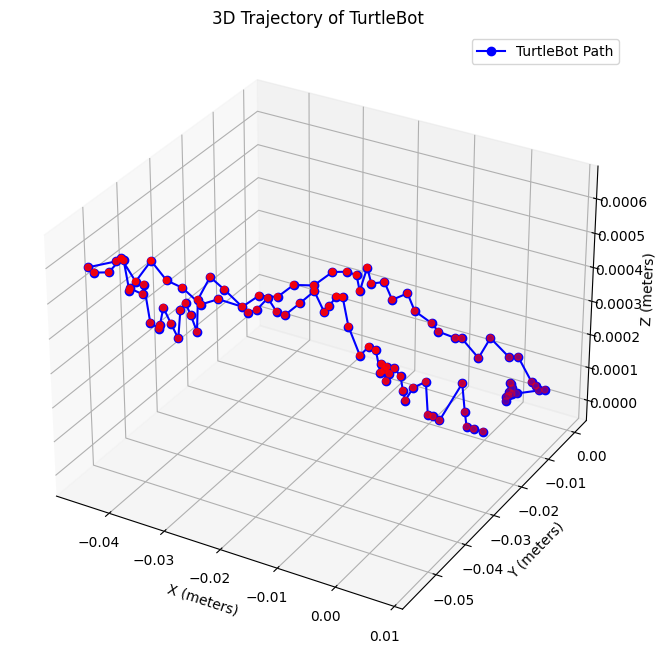

In [ ]:
# Load all .pcd files 
pcd_files_name = sorted(glob.glob("selected_pcds/*.pcd")) 
point_clouds = load_point_clouds(*pcd_files_name)

# Initialize global transformation matrix as identity
global_transformation = np.identity(4)

# List to store trajectory (x, y, z)
trajectory = [[0, 0, 0]]  # Start at origin

# Merged global point cloud
merged_pcd = o3d.geometry.PointCloud()

for i in range(len(point_clouds)-1):
    pcd1 = point_clouds[i]
    pcd2 = point_clouds[i+1]

    # Compute initial transformation using RANSAC
    T = get_ransac_initial_guess(pcd1, pcd2)

    # Perform ICP with the best threshold = 0.05
    icp_result = ICP(pcd1, pcd2, T, threshold=0.05)  

    # Update global transformation
    global_transformation = np.dot(global_transformation, icp_result.transformation)

    # Apply transformation to source point cloud
    pcd1.transform(global_transformation)

    # Update trajectory
    trajectory.append(global_transformation[:3, 3].tolist())  # Extract (x, y, z)

    # Merge transformed point cloud into the global model
    merged_pcd += pcd1

# Save the final merged point cloud
o3d.io.write_point_cloud("global_registered.pcd", merged_pcd)

# Save trajectory to CSV
trajectory = np.array(trajectory)
trajectory_df = pd.DataFrame(trajectory, columns=["x", "y", "z"])
trajectory_df.to_csv("turtlebot_trajectory.csv", index=False)

# Plot the trajectory in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], 'bo-', label="TurtleBot Path")
ax.scatter3D(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2], c='r', marker='o') 
ax.set_xlabel("X (meters)")
ax.set_ylabel("Y (meters)")
ax.set_zlabel("Z (meters)")
ax.set_title("3D Trajectory of TurtleBot")
ax.legend()
ax.grid()
plt.show()